In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import random
import matplotlib.pyplot as plt

In [2]:
class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_wealth, norm): # Norm = 0  or 1 corresponding to selfish or altruistic behavior
        super().__init__(unique_id, model)
        self.norm = norm
        self.wealth = initial_wealth

  

    def step(self):
        self.generate_wealth()
        self.expenditure()
        self.trade()
        self.wealth_transfer()
        self.social_influence()


    def generate_wealth(self):
        # Proportional wealth increase.
        self.wealth *= 1 + self.model.growth_rate

        # Fixed wealth increase which emulates a salary from a job. # This should depend on employment status.
        self.wealth += self.model.salary

    def expenditure(self):
        self.wealth -= self.model.expenditure
    
    def trade(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        # Pick a random neighbor
        neighbor = self.random.choice(neighbors)

        # Wealth transfer between agents based on trade ratio.
        trade_amount = self.model.trade_ratio * self.wealth
        self.wealth -= trade_amount
        neighbor.wealth += trade_amount

    def wealth_transfer(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        # Pick a random neighbor
        neighbor = self.random.choice(neighbors)

        # Check if norm of the agent is altruistic
        if self.norm == 1:
            # Only donate if the neighbor is poorer than the agent.
            if neighbor.wealth < self.wealth:

                # Wealth transfer between agents based on trade ratio.
                wealth_transfer = self.model.donation_ratio * self.wealth
                self.wealth -= wealth_transfer
                neighbor.wealth += wealth_transfer

                # Update behaviour of the neighbor if neighbor is selfish
                if neighbor.norm == 0: # Tit for tat
                    neighbor.norm = 1
    
    def social_influence(self): #TODO need to check
        # Change your norm if majority of your neighbors in the network are of the same norm
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return
        
        norm_counts = {}
        for neighbor in neighbors:
            if neighbor.norm in norm_counts:
                norm_counts[neighbor.norm] += 1
            else:
                norm_counts[neighbor.norm] = 1
        
        majority_norm = max(norm_counts, key=norm_counts.get)
        majority_norm_count = norm_counts[majority_norm]
        
        if majority_norm_count > len(neighbors) / 2:
            self.norm = majority_norm


class SocialNormModel(Model):
    def __init__(self, num_agents, avg_node_degree, rewiring_prob, initial_wealth, growth_rate, trade_ratio, salary, expenditure, donation_ratio, ratio_of_altruistic_agents):
        self.num_agents = num_agents
        self.growth_rate = growth_rate
        self.trade_ratio = trade_ratio
        self.salary = salary
        self.expenditure = expenditure
        self.donation_ratio = donation_ratio

        # Create network
        self.G = nx.watts_strogatz_graph(n=num_agents, k=avg_node_degree, p=rewiring_prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            # Determine if the agent is altruistic based on the given ratio
            if random.random() < ratio_of_altruistic_agents:
                norm = 1
            else:
                norm = 0

            agent = SocialAgent(unique_id=i, model=self, initial_wealth=initial_wealth, norm=norm)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        # Data collector (optional)
        self.datacollector = DataCollector(
            agent_reporters={"Wealth": "wealth", "Norm": "norm"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def run_model(self, n):
        for _ in range(n):
            self.step()



In [23]:


# Example usage
params = {
    "num_agents": 100, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.1,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 1, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.153 # Main thing that we change #0.152 to 0.153
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# Data collection results
data = model.datacollector.get_agent_vars_dataframe()
print(data)

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_24089/2635958565.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


                    Wealth  Norm
Step AgentID                    
0    0        1.000000e+02     0
     1        1.000000e+02     0
     2        1.000000e+02     0
     3        1.000000e+02     0
     4        1.000000e+02     1
...                    ...   ...
999  56      -9.095842e+06     1
     24      -9.319917e+06     1
     88      -9.965935e+06     1
     21      -2.629540e+06     1
     42      -7.085493e+06     1

[100000 rows x 2 columns]


<Axes: xlabel='Step'>

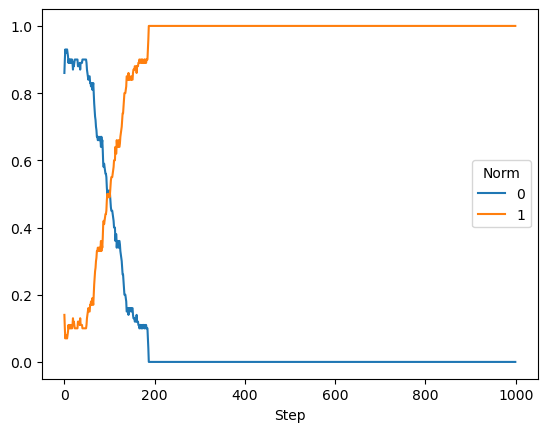

In [24]:
# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
